In [ ]:
! pip install umap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=b046602f84e364364541c196977a8978ac069186108207c400424dbe475b14bc
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap


In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import keras
from keras.applications.vgg16 import preprocess_input,VGG16
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from zipfile import ZipFile
file_name = ('/content/archive (4).zip')

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
# Function to load images

def convert_image_to_dataset(file_location):
    label=0
    df=pd.DataFrame()
    for category in glob(file_location+'/*'):
        for file in tqdm(glob(category+'/*')):
            img_array=cv2.imread(file)
            img_array=cv2.resize(img_array,(224, 224))
            data=pd.DataFrame({'image':[img_array],'label':[label]})
            df=df.append(data)
        label+=1
    return df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Function to convert output labels to its class of tumor.


def inverse_classes(num):
    if num==0:
        return 'Glioma Tumor'
    elif num==1:
        return 'Meningioma Tumor'
    elif num==2:
        return 'No Tumor'
    else:
        return 'Pituitary Tumor'
    

In [ ]:
train_data=convert_image_to_dataset('/content/Training/')
train_x=np.array(train_data.image.to_list())

100%|██████████| 827/827 [00:07<00:00, 104.83it/s]


In [ ]:
test_data=convert_image_to_dataset('/content/Testing/')
test_x=np.array(test_data.image.to_list())


100%|██████████| 74/74 [00:01<00:00, 64.72it/s]


# Visualizing Dataset

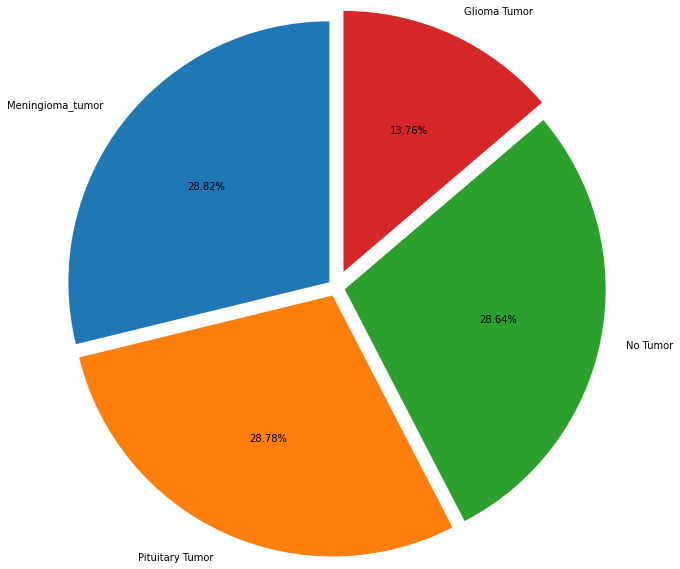

In [ ]:
plt.pie(train_data.label.value_counts(),startangle=90,explode=[0.1,0.1,0.1,0.2],autopct='%0.2f%%',
        labels=['Meningioma_tumor', 'Pituitary Tumor', 'No Tumor', 'Glioma Tumor'],radius=3)
plt.show()

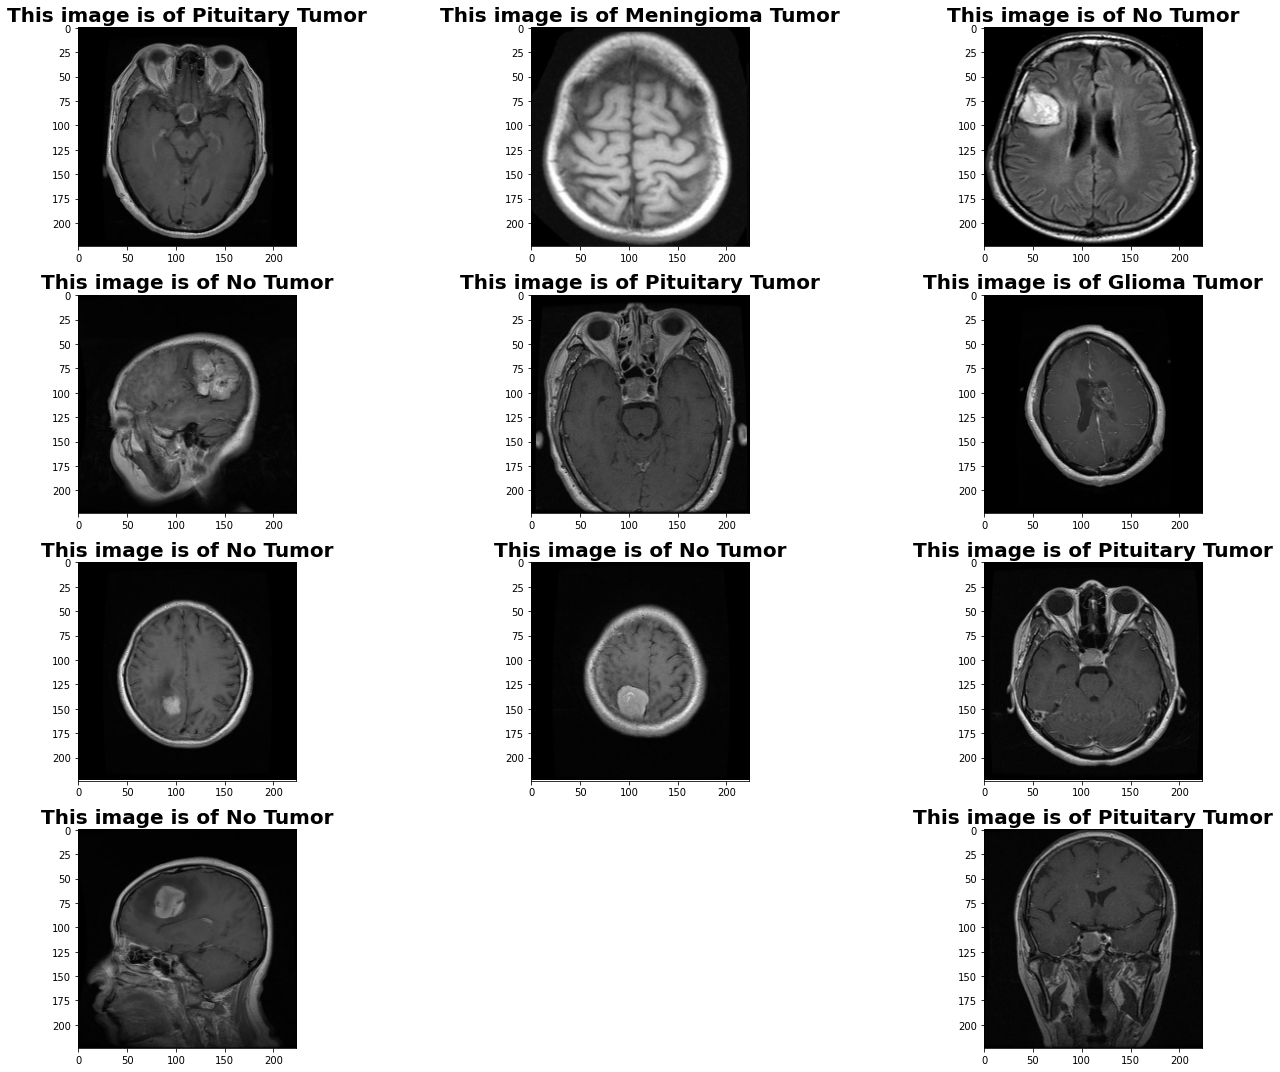

In [ ]:
plt.figure(figsize=(20,15))
for i in range(12):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(2000)
    plt.title('This image is of {0}'.format(inverse_classes(train_data.label[index])),fontdict={'size':20,'weight':'bold'})
    plt.imshow(train_data.image[index])
    plt.tight_layout()

# Callbacks Functions


In [ ]:
early_stop=EarlyStopping(patience=3)
reduceLR=ReduceLROnPlateau(patience=2)

In [ ]:
model_cnn=Sequential()
model_cnn.add(Input(shape=(224,224,3)))
model_cnn.add(Conv2D(128,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(64,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(32,(3,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Flatten())
model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(64,activation='relu'))
model_cnn.add(Dense(4,activation='softmax'))
model_cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

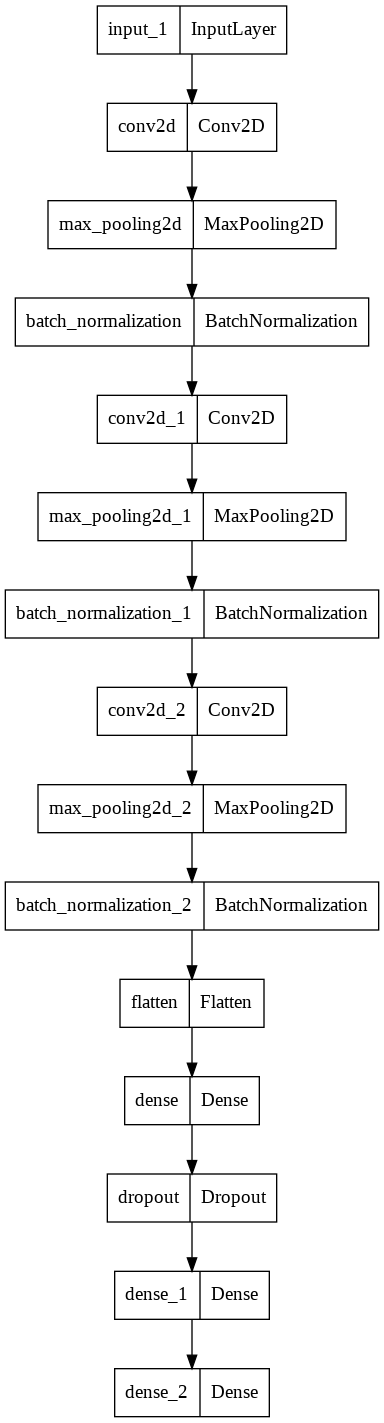

In [ ]:
plot_model(model_cnn)



In [ ]:
r1=model_cnn.fit(train_x,train_data.label,validation_split=0.1,epochs=20,callbacks=[reduceLR])


Epoch 1/20
81/81 [==============================] - 24s 125ms/step - loss: 1.2299 - accuracy: 0.5865 - val_loss: 1.6938 - val_accuracy: 0.6202 - lr: 0.0010
Epoch 2/20
81/81 [==============================] - 8s 102ms/step - loss: 0.7903 - accuracy: 0.7182 - val_loss: 2.0624 - val_accuracy: 0.4774 - lr: 0.0010
Epoch 3/20
81/81 [==============================] - 8s 102ms/step - loss: 0.5354 - accuracy: 0.7890 - val_loss: 2.6272 - val_accuracy: 0.5192 - lr: 0.0010
Epoch 4/20
81/81 [==============================] - 8s 102ms/step - loss: 0.3824 - accuracy: 0.8494 - val_loss: 0.6749 - val_accuracy: 0.7038 - lr: 1.0000e-04
Epoch 5/20
81/81 [==============================] - 8s 102ms/step - loss: 0.2887 - accuracy: 0.8858 - val_loss: 0.6002 - val_accuracy: 0.7387 - lr: 1.0000e-04
Epoch 6/20
81/81 [==============================] - 8s 102ms/step - loss: 0.2548 - accuracy: 0.9013 - val_loss: 0.3531 - val_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 7/20
81/81 [==============================] - 8s 10

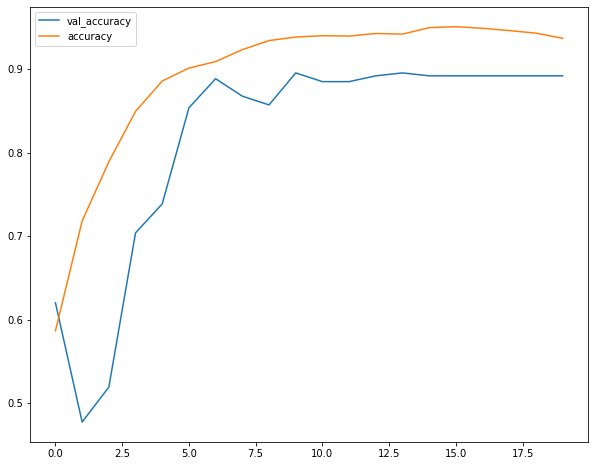

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r1.history['val_accuracy'])
plt.plot(r1.history['accuracy'])
plt.legend(['val_accuracy','accuracy'])
plt.show()

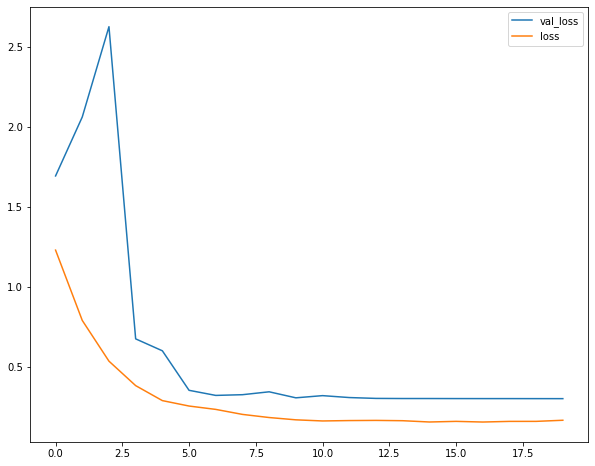

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r1.history['val_loss'])
plt.plot(r1.history['loss'])
plt.legend(['val_loss','loss'])
plt.show()

In [ ]:
# Predictions on Test Datasets using CNN model

test_pred=np.argmax(model_cnn.predict(test_x),axis=1)
print(classification_report(test_data.label,test_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25       100
           1       0.60      0.95      0.74       105
           2       0.67      0.86      0.75       115
           3       0.92      0.82      0.87        74

    accuracy                           0.70       394
   macro avg       0.80      0.69      0.65       394
weighted avg       0.78      0.70      0.64       394



# Visualizing Prediction on test dataset

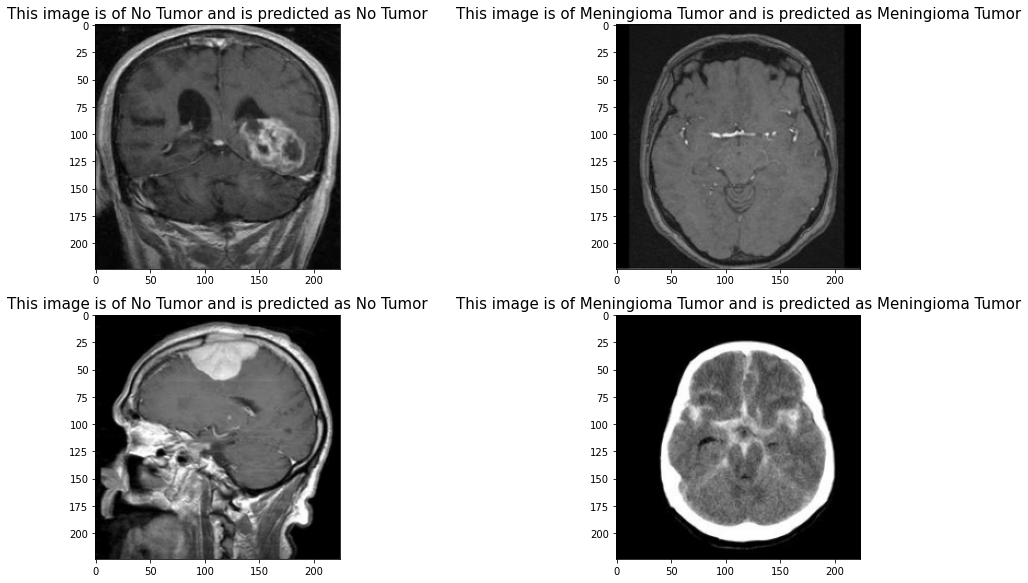

In [ ]:
# Prediction using CNN model

plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(200)
    pred_class=inverse_classes(np.argmax(model_cnn.predict(np.reshape(test_x[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(test_data.label[index]),pred_class),
              fontdict={'size':15})
    plt.imshow(test_x[index])
    plt.tight_layout()